# Chile 2024 Local elections results analysis.
### Crossing with sociodemographic data by County (comuna)

1. To construct the electoral data we need to download three JSON files frome the Electoral service webpage. This are the Territory dataset (which contains the ID's and names of the electoral districts); the Candidates dataset (which contains the ID's and names for the Candidates)m and the REsults 
Territories: https://provisorios.servel.cl/territorios.zip   
Candidates: https://provisorios.servel.cl/candidaturas.zip   
Results by voting table (which has the individual votes for each candidate in each mesa electoral)    
https://provisorios.servel.cl/nomina_completa_3.zip. This Zip contains the Json. Is not in online Repo because is over 100MB.

    Each candidate is part of a pacto list and may be part of a sub-pacto, which is an internal D'hont run inside the List to assign the seats won between the parties member of a given Pacto. 
    After merging all the data sets, I label all observations as being "opposition" or "government" and sum the votes for each group at the county (comuna) level, reducing the 2,5 millions observation dataset into 365. 

2. After this, I upload the poverty index by comuna published in 2024 and merge it with the grouped results, to analyze correlation between poverty levels and political alignment 


## 1. election results cleaning 

In [1]:
import json
import pandas as pd
from unidecode import unidecode


# Import of the data base of municipal councilors election in 2024
with open('input/nomina_completa_3.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# un nest the json to a table with the mesa id as the key
tabla_mesas = pd.json_normalize(data).drop(columns=['candidatos'])

# un nest the json to a table with the candidate id as the key
tabla_candiadatos = pd.json_normalize(data, record_path='candidatos', meta = 'id_mesa')

# We merge the tables to make one longer unnested table
tabla_mesas_cands = tabla_candiadatos.merge(tabla_mesas, on='id_mesa', how='left')
#transformamos variable id_mesa a numeric para hacer el merge con los labels dsps
tabla_mesas_cands['id_mesa'] = pd.to_numeric(tabla_mesas_cands['id_mesa'])


# Import of string labels of ID's of territories and candidates
cand_labels = pd.read_json('input/candidaturas.json')
territorios = pd.read_json('input/territorios.json')

# Merge of results with string labels 
merge_cand = tabla_mesas_cands.merge(cand_labels, on='id_candidato', 
how='left', suffixes = ('', '_remove'))

merge_cand_mesa = merge_cand.merge(territorios, on='id_mesa', 
how='left', suffixes = ('', '_remove'))

merge_cand_mesa.drop([i for i in merge_cand_mesa.columns if '_remove' in i],
axis=1, inplace=True)

# selecting of relevant vars

vars = ['id_eleccion', 'orden_region', 'region', 
'orden_cirsen', 'orden_distrito', 'provincia', 
'circ_provincial', 'cupos_core', 'comuna', 
'cupos_concejal', 'id_local', 'local', 
'mesa', 'id_mesa', 'electores', 'pacto', 'glosa_subpacto', 
'partido', 'sigla_partido', 'id_candidato', 'candidato', 
'votos', 'electo', 'blancos', 'nulos']

mesa_id_vars = ['id_eleccion', 'orden_region', 'region', 
'orden_cirsen', 'orden_distrito', 'provincia', 
'circ_provincial', 'cupos_core', 'comuna', 
'cupos_concejal', 'id_local', 'local', 
'mesa', 'id_mesa', 'electores']

cand_id_vars= ['pacto', 'glosa_subpacto', 
'partido', 'sigla_partido', 'id_candidato', 'candidato', 
'votos', 'electo']

cut_merge = merge_cand_mesa[vars]

# pivot longer de nulos y blancos 

melt_vars = ['id_eleccion', 'orden_region', 'region', 
'orden_cirsen', 'orden_distrito', 'provincia', 
'circ_provincial', 'cupos_core', 'comuna', 
'cupos_concejal', 'id_local', 'local', 
'mesa', 'id_mesa', 'electores', 'blancos', 'nulos'] 

# pass blank and nule votes from separate variables to candidates
melt_b_n = cut_merge[melt_vars].drop_duplicates(subset=['id_mesa'])

melt_b_n = pd.melt(melt_b_n, id_vars= mesa_id_vars, 
                                value_vars=['blancos', 'nulos'],
                                var_name='candidato', 
                                value_name='votos')

df_combined = pd.concat([cut_merge, melt_b_n], ignore_index=True)


#renaming de variables, sorting and drop
id_mapping = {7: 'core', 3: 'concejales', 1: 'gore', 2: 'alcalde'}
df_combined['id_eleccion'] = df_combined['id_eleccion'].map(id_mapping)

df_combined = df_combined.rename(columns={
    'orden_region': 'region_numero',
    'orden_cirsen': 'circ_sen',
    'orden_distrito': 'distrito',
    'glosa_subpacto': 'subpacto'}).sort_values(
        
    by=['distrito', 'comuna','local', 'id_mesa',
    'pacto', 'subpacto', 'partido', 'candidato'],
    ignore_index=True
    ).drop(columns=
        ['blancos', 'nulos']
    )

# replace pacto missings in the case of out of list candidates and blank/nule votes
df_combined['pacto'] = df_combined.apply(lambda row: 'blancos_nulos' if row['candidato'] in ['blancos', 'nulos'] else row['pacto'], axis=1)
df_combined.loc[(df_combined['pacto'].isna()) & (df_combined['partido'] == 'INDEPENDIENTES'), 'pacto'] = 'INDEPENDIENTES'

In [2]:
# drop long intermediate tables created
for var in ['cut_merge', 'merge_cand_mesa', 'merge_cand', 'melt_b_n',
 'tabla_candiadatos', 'tabla_mesas', 'tabla_mesas_cands', 'territorios',
 'cand_labels', 'data']:
    if var in globals():
        del globals()[var]

In [3]:
# create variable 'sector' which for almost all observations is binary opposition vs governemnt  
sector_dict = {
    'CENTRO DEMOCRATICO': 'oposicion',
    'CHILE MUCHO MEJOR': 'oficialismo',
    'CHILE VAMOS RENOVACIÓN NACIONAL - INDEPENDIENTES': 'oposicion',
    'CHILE VAMOS UDI-EVOPOLI E INDEPENDIENTES': 'oposicion',
    'IZQUIERDA DE TRABAJADORES E INDEPENDIENTES': 'oficialismo',
    'IZQUIERDA ECOLOGISTA POPULAR': 'oficialismo',
    'PARTIDO DE LA GENTE E INDEPENDIENTES': 'oposicion',
    'POR CHILE, SEGUIMOS': 'oficialismo',
    'REPUBLICANOS E INDEPENDIENTES': 'oposicion',
    'VERDES LIBERALES POR UNA COMUNA SEGURA': 'oficialismo',
    'PARTIDO SOCIAL CRISTIANO E INDEPENDIENTES': 'oposicion',
    'ECOLOGISTAS, ANIMALISTAS E INDEPENDIENTES': 'oficialismo',
    'blancos_nulos': 'blancos_nulos',
    'INDEPENDIENTES': 'independendientes',
    'TU COMUNA RADICAL': 'oficialismo'
}

# Map the sector dictionary to the pacto column in df_combined
df_combined['sector'] = df_combined['pacto'].map(sector_dict)

In [4]:

# Create dummy variables for the 'sector' column
df_combined = pd.get_dummies(df_combined, columns=['sector'], prefix='sector', dtype=float)

# Display the first few rows to verify
df_combined.head()

,id_eleccion,region_numero,region,circ_sen,distrito,provincia,circ_provincial,cupos_core,comuna,cupos_concejal,...,partido,sigla_partido,id_candidato,candidato,votos,electo,sector_blancos_nulos,sector_independendientes,sector_oficialismo,sector_oposicion
0,concejales,1,DE ARICA Y PARINACOTA,1,1,ARICA,ARICA,11,ARICA,10,...,INDEPENDIENTES,IND,14103474.0,ALEJANDRA ANDREA ALARCON FUENTES,2,0.0,0.0,0.0,0.0,1.0
1,concejales,1,DE ARICA Y PARINACOTA,1,1,ARICA,ARICA,11,ARICA,10,...,INDEPENDIENTES,IND,13863915.0,CAROLINA ANDREA OLIVARES VERGARA,1,0.0,0.0,0.0,0.0,1.0
2,concejales,1,DE ARICA Y PARINACOTA,1,1,ARICA,ARICA,11,ARICA,10,...,INDEPENDIENTES,IND,14104407.0,CRISTIAN ANDRES VERGARA CALQUIN,0,0.0,0.0,0.0,0.0,1.0
3,concejales,1,DE ARICA Y PARINACOTA,1,1,ARICA,ARICA,11,ARICA,10,...,INDEPENDIENTES,IND,13637437.0,GEMITA ROSARIO PUENTE MEZA,5,0.0,0.0,0.0,0.0,1.0
4,concejales,1,DE ARICA Y PARINACOTA,1,1,ARICA,ARICA,11,ARICA,10,...,INDEPENDIENTES,IND,8243493.0,GEORGINA PATRICIA SANTANDER MENDEZ,0,0.0,0.0,0.0,0.0,1.0


In [5]:
# Group by comuna and sector_oficialismo and sum all votos
# all not goverment votes are summed in votes_opp
grouped_df = df_combined.groupby(['comuna', 'sector_oficialismo'])['votos'].sum().reset_index()

# Pivot the table to have separate columns for votes_opp and votes_gov
pivot_df = grouped_df.pivot(index='comuna', columns='sector_oficialismo', values='votos').reset_index()

# Fill NaN values with 0
pivot_df = pivot_df.fillna(0)

# Rename columns to match the required output
pivot_df = pivot_df.rename(columns={0: 'votes_opp', 1: 'votes_gov'})

# Display the resulting dataframe
pivot_df.head()

sector_oficialismo,comuna,votes_opp,votes_gov
0,ALGARROBO,10476.0,4986.0
1,ALHUE,2142.0,3648.0
2,ALTO BIOBIO,2931.0,2183.0
3,ALTO DEL CARMEN,2062.0,2206.0
4,ALTO HOSPICIO,39432.0,17770.0


In [77]:
# Calculate total votes
pivot_df['total_votes'] = pivot_df['votes_opp'] + pivot_df['votes_gov']

# Calculate opposition share
pivot_df['opp_share'] = pivot_df['votes_opp'] / pivot_df['total_votes']

# Calculate government share
pivot_df['gov_share'] = pivot_df['votes_gov'] / pivot_df['total_votes']

# Display the resulting dataframe
pivot_df.head()


sector_oficialismo,comuna,votes_opp,votes_gov,total_votes,opp_share,gov_share
0,algarrobo,10476.0,4986.0,15462.0,0.677532,0.322468
1,alhue,2142.0,3648.0,5790.0,0.369948,0.630052
2,alto biobio,2931.0,2183.0,5114.0,0.573133,0.426867
3,alto del carmen,2062.0,2206.0,4268.0,0.483130,0.516870
4,alto hospicio,39432.0,17770.0,57202.0,0.689347,0.310653


In [78]:
# drop antartica comuna because is included in results from Cabo de Hornos
pivot_df = pivot_df[pivot_df['comuna'] != 'ANTARTICA']

# rename cabo de hornos to match CASEN data
pivot_df['comuna'] = pivot_df['comuna'].replace('CABO DE HORNOS(EX-NAVARINO)', 'CABO DE HORNOS')

# De-unicode and convert to lower case
pivot_df['comuna'] = pivot_df['comuna'].apply(lambda x: unidecode(x).lower())

# Display the resulting dataframe
pivot_df.head() 

sector_oficialismo,comuna,votes_opp,votes_gov,total_votes,opp_share,gov_share
0,algarrobo,10476.0,4986.0,15462.0,0.677532,0.322468
1,alhue,2142.0,3648.0,5790.0,0.369948,0.630052
2,alto biobio,2931.0,2183.0,5114.0,0.573133,0.426867
3,alto del carmen,2062.0,2206.0,4268.0,0.483130,0.516870
4,alto hospicio,39432.0,17770.0,57202.0,0.689347,0.310653


## 2. Poverty index treating and merging

In [79]:
# Read the Excel file into a DataFrame
df_pov_index = pd.read_excel('input/pov_index.xlsx')

# deunicode and convert to lower case
df_pov_index['comuna'] = df_pov_index['comuna'].apply(lambda x: unidecode(x).lower())

# fix mismatch of comuna spelling between the two dataframes
df_pov_index['comuna'] = df_pov_index['comuna'].replace({
    'paiguano': 'paihuano',
    'treguaco': 'trehuaco',
    'marchihue': 'marchigue',
    'llaillay': 'llay-llay'
})

# Display the resulting dataframe
df_pov_index.head()

,code,region,comuna,pop,poors,prop_poors,prop_poors_lower,prop_poors_upper
0,1101,Tarapacá,iquique,229674,41966.566241,0.182722,0.162429,0.203015
1,1107,Tarapacá,alto hospicio,138527,45162.442981,0.326019,0.294776,0.357263
2,1401,Tarapacá,pozo almonte,18290,4563.395313,0.249502,0.199334,0.299671
3,1402,Tarapacá,camina,1380,307.626999,0.222918,0.137766,0.308071
4,1403,Tarapacá,colchane,1575,472.752772,0.300160,0.187495,0.412826


In [80]:
# Merge the two dataframes by "comuna" value
merged_df = pd.merge(pivot_df, df_pov_index, on='comuna', how='inner')

# Display the resulting dataframe
merged_df.head()

,comuna,votes_opp,votes_gov,total_votes,opp_share,gov_share,code,region,pop,poors,prop_poors,prop_poors_lower,prop_poors_upper
0,algarrobo,10476.0,4986.0,15462.0,0.677532,0.322468,5602,Valparaíso,15724,3079.295721,0.195834,0.141023,0.250645
1,alhue,2142.0,3648.0,5790.0,0.369948,0.630052,13502,Metropolitana,7691,2238.877109,0.291104,0.225365,0.356842
2,alto biobio,2931.0,2183.0,5114.0,0.573133,0.426867,8314,Biobío,6784,2639.780468,0.389119,0.318695,0.459542
3,alto del carmen,2062.0,2206.0,4268.0,0.483130,0.516870,3302,Atacama,5763,1606.933028,0.278836,0.188863,0.368810
4,alto hospicio,39432.0,17770.0,57202.0,0.689347,0.310653,1107,Tarapacá,138527,45162.442981,0.326019,0.294776,0.357263


## 3. graphs

In [69]:
import altair as alt

# Create a scatter plot with a regression line
scatter_plot = alt.Chart(merged_df).mark_point(filled=True, size=60).encode(
    x=alt.X('prop_poors', title='Proportion of Poors'),
    y=alt.Y('opp_share', title='Opposition Share'),
    color=alt.Color('region', title='Region'),
    size=alt.Size('pop', title='Population', scale=alt.Scale(range=[20, 400])),
    tooltip=['comuna', 'prop_poors', 'opp_share', 'region', 'pop']
).properties(
    title='Opposition Share vs. Proportion of Poors by Comuna',
    width=800,
    height=400
)

# Add a regression line
regression_line = scatter_plot.transform_regression(
    'prop_poors', 'opp_share'
).mark_line(color='blue')

# Combine the scatter plot and regression line
final_plot = scatter_plot + regression_line

# Display the plot
final_plot

# Combine the scatter plot and regression line
final_plot = scatter_plot + regression_line

# Display the plot
final_plot

final_plot.save('chart.json')

final_plot

/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/c

alt.LayerChart(...)

In [75]:
import pandas as pd
import altair as alt

# Bin the comunas into 4 equal-sized bins based on 'prop_poors'
merged_df['prop_poors_bin'] = pd.qcut(merged_df['prop_poors'], q=4, labels=["Bin 1", "Bin 2", "Bin 3", "Bin 4"])

# Create the Altair plot
chart = alt.Chart(merged_df).mark_point(filled=True, size=60).encode(
    x=alt.X('opp_share', title='Opposition Share'),
    y=alt.Y('prop_poors_bin', title='Proportion of Poors Bin'),
    color='prop_poors_bin:N',  # Color by the population bin
    tooltip=['comuna', 'opp_share', 'prop_poors', 'prop_poors_bin']  # Tooltip for extra information
).properties(
    title="Opposition Share by Proportion of Poors Bin"
)

# Display the chart
chart

chart.save('chart_9-2.json')




/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


### x Expermiental trying confidence intervals and multi variate regression

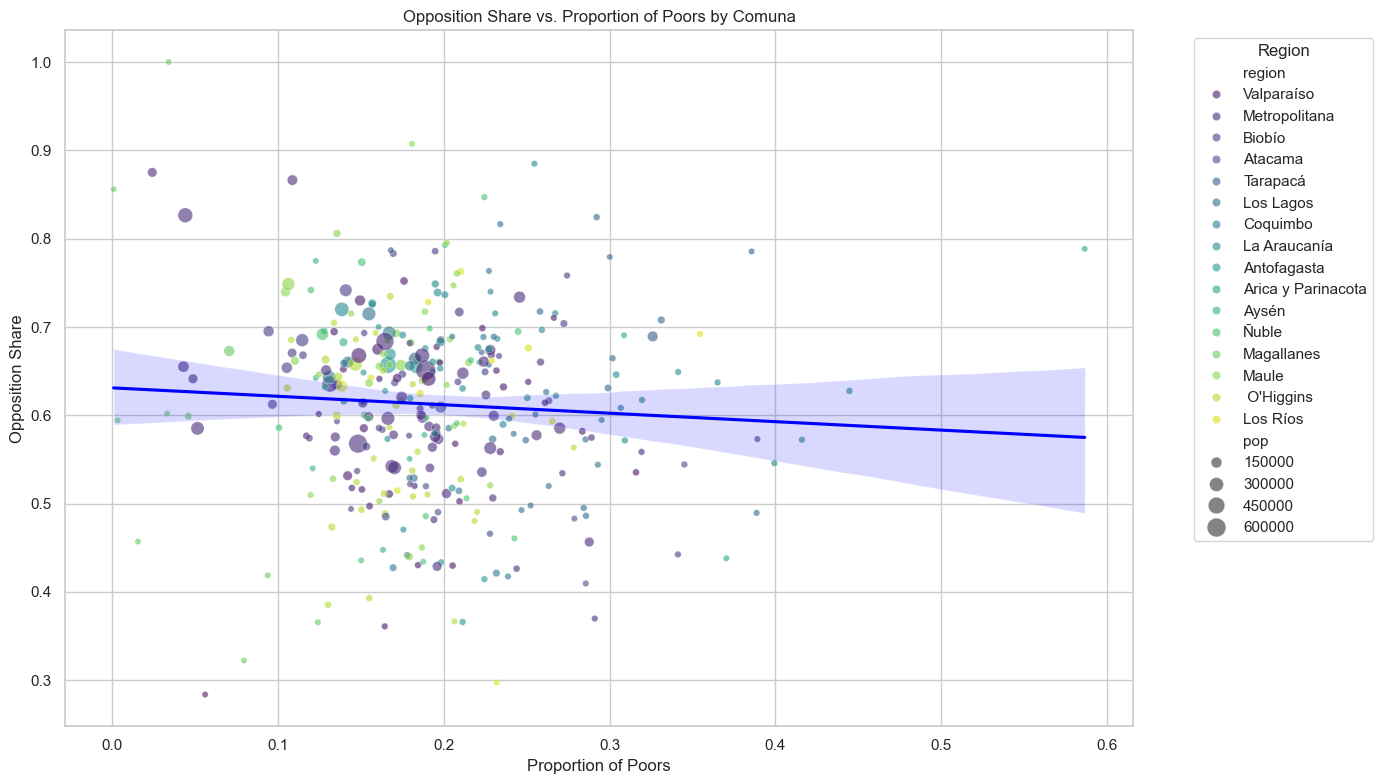

In [62]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a scatter plot with a regression line
plt.figure(figsize=(14, 8))
scatter_plot = sns.scatterplot(
    data=merged_df,
    x='prop_poors',
    y='opp_share',
    size='pop',
    hue='region',
    palette='viridis',
    sizes=(20, 200),
    alpha=0.6,
    edgecolor='w',
    legend='brief'
)

# Add a regression line
sns.regplot(
    data=merged_df,
    x='prop_poors',
    y='opp_share',
    scatter=False,
    color='blue'
)

# Customize the plot
plt.title('Opposition Share vs. Proportion of Poors by Comuna')
plt.xlabel('Proportion of Poors')
plt.ylabel('Opposition Share')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

In [56]:
merged_df.columns

Index(['comuna', 'votes_opp', 'votes_gov', 'total_votes', 'opp_share',
       'gov_share', 'code', 'region', 'pop', 'poors', 'prop_poors',
       'prop_poors_lower', 'prop_poors_upper', 'predicted_opp_share',
       'ci_lower', 'ci_upper', 'fitted'],
      dtype='object')

In [ ]:
import pandas as pd
import altair as alt

# Sample data (replace with your actual dataset)
data = [
    {
        "comuna": "algarrobo",
        "votes_opp": 10476.0,
        "votes_gov": 4986.0,
        "total_votes": 15462.0,
        "opp_share": 0.6775320139697323,
        "gov_share": 0.3224679860302678,
        "code": 5602,
        "region": "Valparaí­so",
        "pop": 15724,
        "poors": 3079.295721400051,
        "prop_poors": 0.1958341211778206,
        "prop_poors_lower": 0.1410234061062501,
        "prop_poors_upper": 0.250644836249391,
        "predicted_opp_share": 0.5839385035864041,
        "ci_lower": 0.5516798031292964,
        "ci_upper": 0.6161972040435117,
        "fitted": 0.5839385035864041
    },
    # Add more comunas here as needed
]

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data)

# Create population bins using qcut (equal-sized bins)
df['pop_bin'] = pd.qcut(df['pop'], q=4, labels=["Bin 1", "Bin 2", "Bin 3", "Bin 4"])

# Plotting with Altair
chart = alt.Chart(df).mark_point(filled=True, size=60).encode(
    x=alt.X('opp_share', title='Opposition Share'),
    y=alt.Y('pop_bin', title='Population Bin'),
    color='pop_bin:N',  # Color by population bin
    tooltip=['comuna', 'opp_share', 'pop', 'pop_bin']  # Tooltip to display info
).properties(
    title="Opposition Share by Population Bin"
)

# Display the chart
chart.show()


                            OLS Regression Results                            
Dep. Variable:              opp_share   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     3.557
Date:                Wed, 08 Jan 2025   Prob (F-statistic):           6.09e-06
Time:                        11:43:16   Log-Likelihood:                 310.53
No. Observations:                 345   AIC:                            -587.1
Df Residuals:                     328   BIC:                            -521.7
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.6159      0

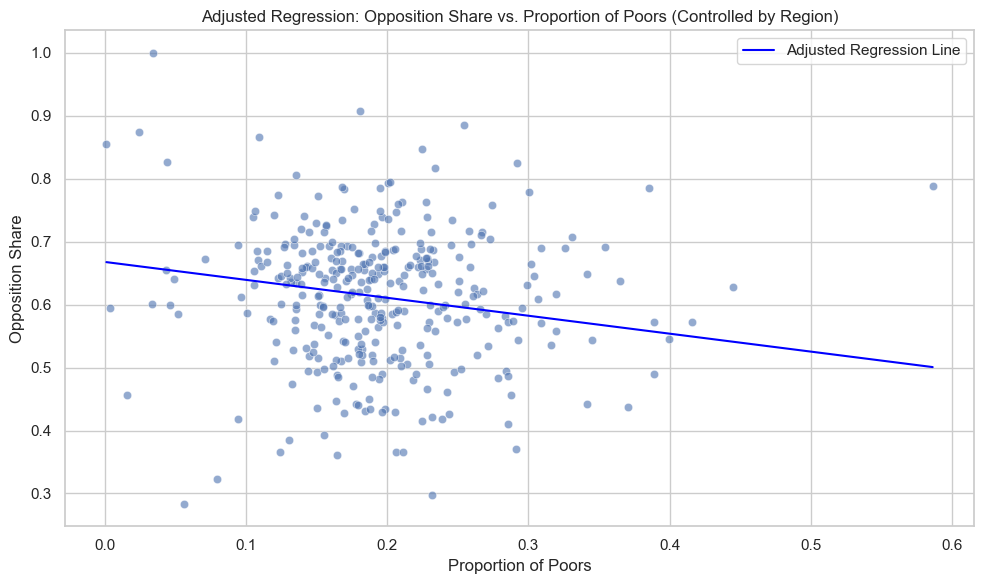

In [25]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# Create dummy variables for 'region'
region_dummies = pd.get_dummies(merged_df['region'], drop_first=True, dtype=float)

# Add dummy variables to the dataframe
X = pd.concat([merged_df[['prop_poors']], region_dummies], axis=1)

# Add a constant for the intercept
X = sm.add_constant(X)

# Define the dependent variable
y = merged_df['opp_share']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Summary of the model
print(model.summary())

# Predict values while controlling for region
X_pred = sm.add_constant(
    pd.DataFrame({
        'prop_poors': np.linspace(merged_df['prop_poors'].min(), merged_df['prop_poors'].max(), 100)
    })
)
# Add mean values for region dummies (effectively controlling for them)
for col in region_dummies.columns:
    X_pred[col] = region_dummies[col].mean()

# Predict the adjusted values
y_pred = model.predict(X_pred)

# Plot the scatter and adjusted regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='prop_poors', y='opp_share', alpha=0.6)
sns.lineplot(x=X_pred['prop_poors'], y=y_pred, color='blue', label='Adjusted Regression Line')

# Customize the plot
plt.title('Adjusted Regression: Opposition Share vs. Proportion of Poors (Controlled by Region)')
plt.xlabel('Proportion of Poors')
plt.ylabel('Opposition Share')
plt.legend()
plt.tight_layout()
plt.show()

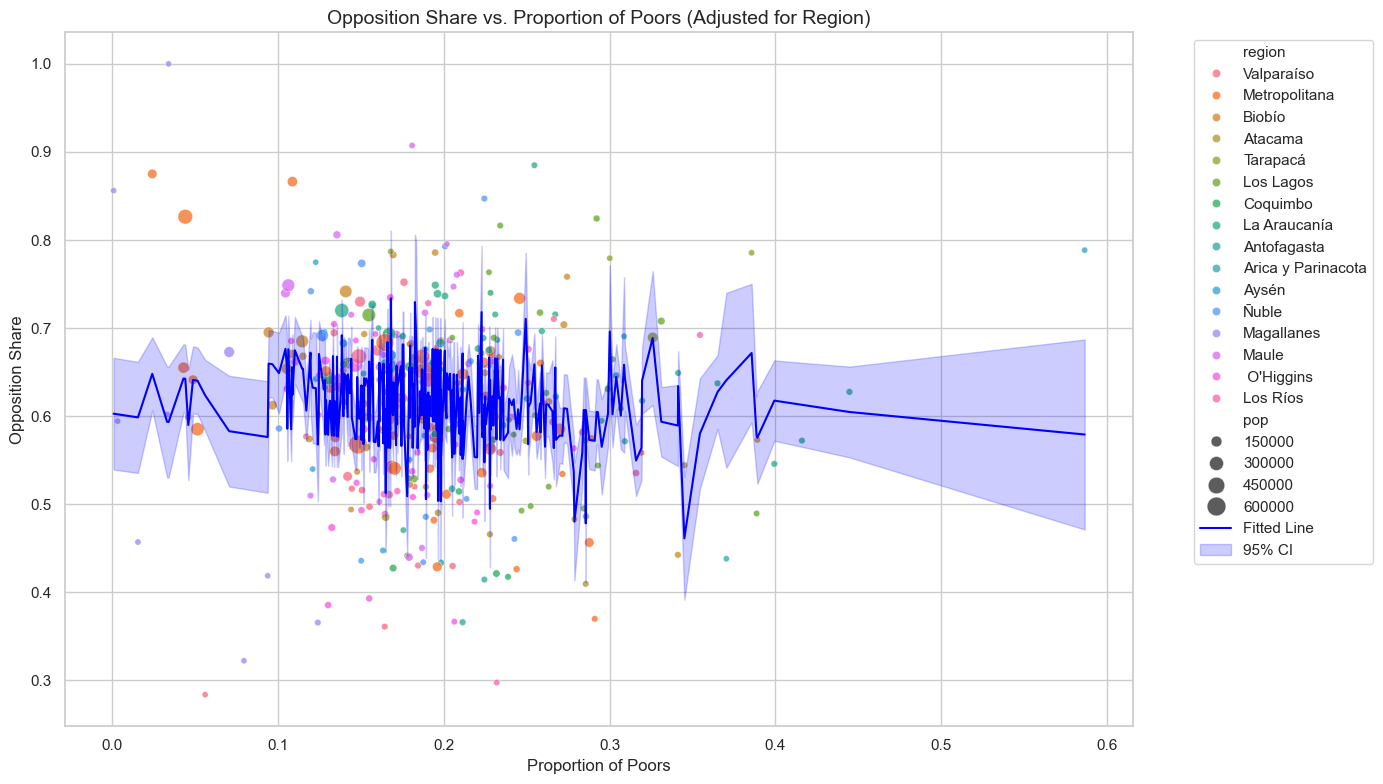

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions and confidence intervals
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Get predictions and standard errors
predictions = model.get_prediction(X)
prediction_summary = predictions.summary_frame(alpha=0.05)

# Add confidence intervals to the DataFrame
merged_df['ci_lower'] = prediction_summary['mean_ci_lower']
merged_df['ci_upper'] = prediction_summary['mean_ci_upper']
merged_df['fitted'] = prediction_summary['mean']

# Create the plot
plt.figure(figsize=(14, 8))

# Scatter points with size by population and color by region
sns.scatterplot(
    data=merged_df,
    x='prop_poors',
    y='opp_share',
    size='pop',
    hue='region',
    sizes=(20, 200),
    alpha=0.8
)

# Sort the DataFrame by the x variable for smooth plotting
sorted_df = merged_df.sort_values(by='prop_poors')

# Add the regression line
plt.plot(
    sorted_df['prop_poors'],
    sorted_df['fitted'],
    color='blue',
    label='Fitted Line'
)

# Add the confidence interval
plt.fill_between(
    sorted_df['prop_poors'],
    sorted_df['ci_lower'],
    sorted_df['ci_upper'],
    color='blue',
    alpha=0.2,
    label='95% CI'
)

# Customize the plot
plt.title('Opposition Share vs. Proportion of Poors (Adjusted for Region)', fontsize=14)
plt.xlabel('Proportion of Poors', fontsize=12)
plt.ylabel('Opposition Share', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

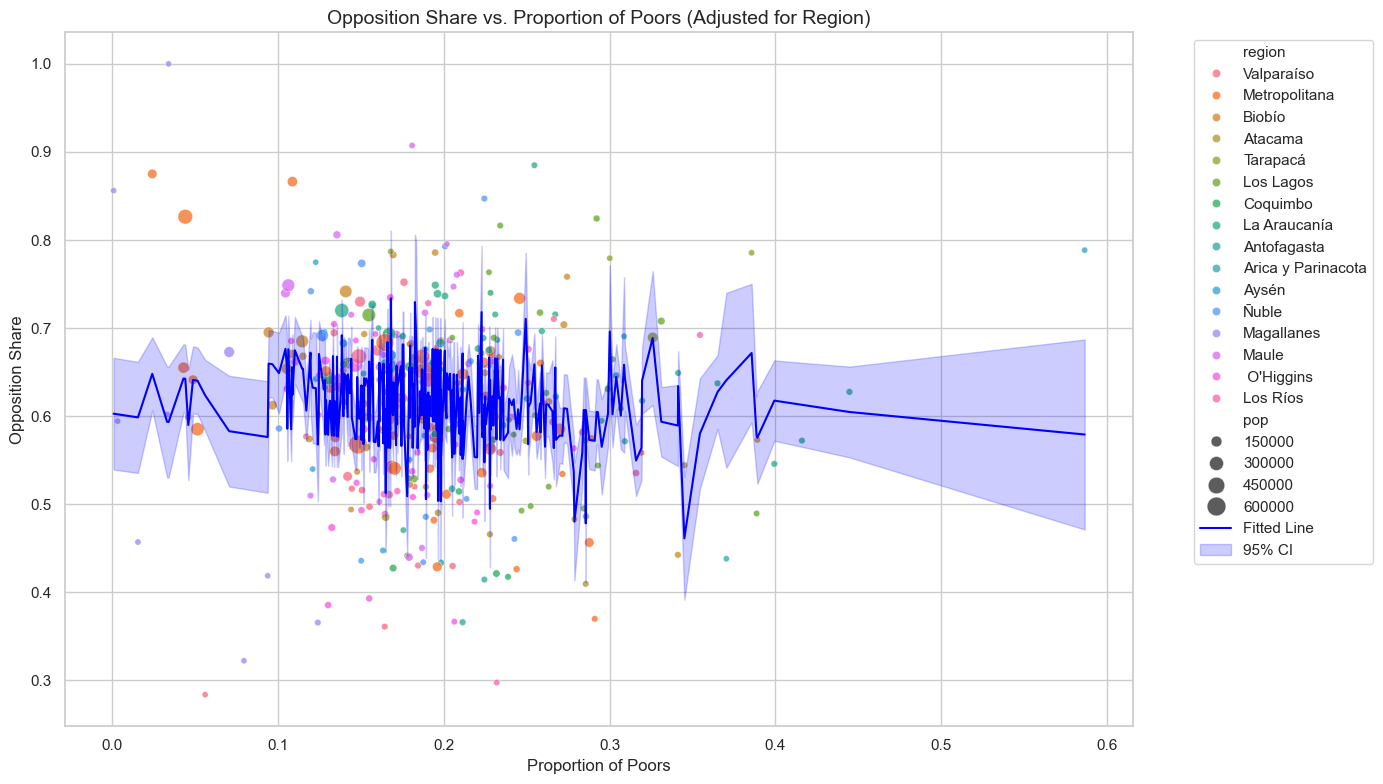

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# Create dummy variables for 'region'
region_dummies = pd.get_dummies(merged_df['region'], drop_first=True, dtype=float)

# Add dummy variables to the dataframe
X = pd.concat([merged_df[['prop_poors']], region_dummies], axis=1)

# Add a constant for the intercept
X = sm.add_constant(X)

# Define the dependent variable
y = merged_df['opp_share']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Generate predictions and confidence intervals
predictions = model.get_prediction(X)
prediction_summary = predictions.summary_frame(alpha=0.05)

# Add confidence intervals to the DataFrame
merged_df['ci_lower'] = prediction_summary['mean_ci_lower']
merged_df['ci_upper'] = prediction_summary['mean_ci_upper']
merged_df['fitted'] = prediction_summary['mean']

# Create the plot
plt.figure(figsize=(14, 8))

# Scatter points with size by population and color by region
sns.scatterplot(
    data=merged_df,
    x='prop_poors',
    y='opp_share',
    size='pop',
    hue='region',
    sizes=(20, 200),
    alpha=0.8
)

# Sort the DataFrame by the x variable for smooth plotting
sorted_df = merged_df.sort_values(by='prop_poors')

# Add the regression line (correct trend line using regression results)
plt.plot(
    sorted_df['prop_poors'],
    sorted_df['fitted'],
    color='blue',
    label='Fitted Line'
)

# Add the confidence interval (correct trend line using regression results)
plt.fill_between(
    sorted_df['prop_poors'],
    sorted_df['ci_lower'],
    sorted_df['ci_upper'],
    color='blue',
    alpha=0.2,
    label='95% CI'
)

# Customize the plot
plt.title('Opposition Share vs. Proportion of Poors (Adjusted for Region)', fontsize=14)
plt.xlabel('Proportion of Poors', fontsize=12)
plt.ylabel('Opposition Share', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()